# Projet détection et reconnaissance - Segmentation sémantique d'images pour un cas d'usage de conduite autonome

### Présenté par team R.O.M.Y - Khedoudja Rym MERAD, Ophélie ENGASSER, Mike DURAN, Yann BEN ABDERRAHMANE - M2-IADS-EL - Juin 2024

# Importation des librairies principales

In [3]:
!pip install tensorflow

  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached ml_dtypes-0.3.2-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached rich-13.7.1-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached op

In [5]:
!pip install tqdm

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.6 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 606.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ---------------------------------------- 78.3/78.3 kB 2.2 MB/s eta 0:00:00


In [1]:
import cv2 as cv
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import json
import tqdm
from IPython.display import clear_output
from collections import Counter

%matplotlib inline

2.16.1


# Exploration des données

Détails des données du dataset: 
- leftmg8bits = images originales (utilisées comme input X).
- gtFine_labelIds = images annotées en niveaux de gris = masques où chaque pixel est mappé à son ID de classe (utilisées comme y). Ce sont les masques qui seront utilisés en association avec les images pour entraîner le modèle.
- gtFine_color = images annotées en couleur = masques d'annotations où chaque classe est représentée par une couleur (utilisées à des fins de visualisation, pas utilisées comme input).
- gtFine_instanceIds = ce sont les instances de chaque catégories, à savoir les identifiants uniques attribués à chaque instance.
- gtFine_polygons = polygones stockés dans un json (ce sont les annotations originales avant transformation au format raster).

Output : masque de segmentation où chaque pixel est classé dans sa catégorie. Même dimension que l'image d'entrée, avec 8 masques de prédictions pour les prédictions brutes, et 1 pour les prédictions argmax (1 pixel = 1 classe ayant la plus forte probabilité). 

Dans ce projet nous avons choisi un encodage des masques avec les labelsIds : chaque pixel = une classe, plutôt qu'un encodage en one-hot où chaque pixel serait représenté par un vecteur de taille 8.

Il est possible de visualiser le dataset sur le repo gitHub lié à Cityscape.
https://github.com/mcordts/cityscapesScripts

Ce repo fournit le schéma des labels (une trentaine) et les 8 sous-catégories sur lesquelles nous allons fonder les sorties du modèle.

In [3]:
from collections import namedtuple

In [3]:
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

In [12]:
Label.category

_tuplegetter(3, 'Alias for field number 3')

In [4]:
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [31]:
# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
id2category     = { label[4]   : label.category for label in labels  }
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

In [34]:
trainId2label

{-1: Label(name='license plate', id=-1, trainId=-1, category='vehicle', categoryId=7, hasInstances=False, ignoreInEval=True, color=(0, 0, 142)),
 18: Label(name='bicycle', id=33, trainId=18, category='vehicle', categoryId=7, hasInstances=True, ignoreInEval=False, color=(119, 11, 32)),
 17: Label(name='motorcycle', id=32, trainId=17, category='vehicle', categoryId=7, hasInstances=True, ignoreInEval=False, color=(0, 0, 230)),
 16: Label(name='train', id=31, trainId=16, category='vehicle', categoryId=7, hasInstances=True, ignoreInEval=False, color=(0, 80, 100)),
 255: Label(name='unlabeled', id=0, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 15: Label(name='bus', id=28, trainId=15, category='vehicle', categoryId=7, hasInstances=True, ignoreInEval=False, color=(0, 60, 100)),
 14: Label(name='truck', id=27, trainId=14, category='vehicle', categoryId=7, hasInstances=True, ignoreInEval=False, color=(0, 0, 70)),
 13: Label(name='car', id

In [19]:
id2category

{0: 'void',
 1: 'flat',
 2: 'construction',
 3: 'object',
 4: 'nature',
 5: 'sky',
 6: 'human',
 7: 'vehicle'}

### Affichage d'une image originale et des couleurs de labels.

In [63]:
path_X = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_X/X_train_stuttgart/stuttgart_000001_000019_leftImg8bit.png"
path_y = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_y/y_train_mask_stuttgart/"

In [65]:
image = Image.open(path_X)
image_color = Image.open(path_y + "stuttgart_000001_000019_gtFine_color.png")
print(image.mode, image_color.mode)
print(image.size, image_color.size)

RGB RGBA
(2048, 1024) (2048, 1024)


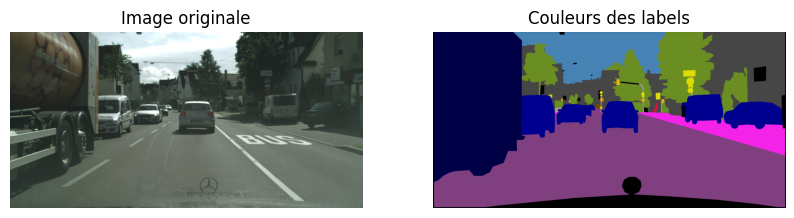

In [69]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1), plt.imshow(image)
plt.title('Image originale')
plt.axis('off')
plt.subplot(2, 2, 2), plt.imshow(image_color)
plt.title('Couleurs des labels')
plt.axis('off');

Sur les images colorées, ce sont les 34 labels qui sont représentés. Nous nous intéresserons dans ce projet à 8 classes uniquement.

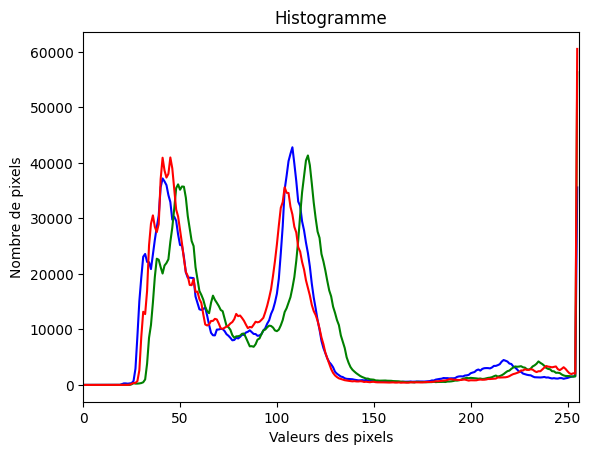

In [26]:
# histogramme de l'image pour les 3 canaux (rouge, vert, bleu)
image_np = np.array(image)

color = ('b','g','r')

for i,col in enumerate(color):
    histr = cv.calcHist([image_np],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogramme')
plt.xlabel('Valeurs des pixels')
plt.ylabel('Nombre de pixels')
plt.show()

L'histogramme nous permet de visualiser la distribution des valeurs de pixels pour chaque canal RBG. Nous voyons ici une répartition suivant le même pattern pour chaque canal, à savoir une majorité de valeurs de pixels dans la plage 25-140 environ, et une allure de la courbe bimodale (modes à 45 et 120 environ).

### Affichage des masques d'annotations

In [79]:
labels = Image.open(path_y + "stuttgart_000001_000019_gtFine_labelIds.png")

In [80]:
print(labels.mode)
print(labels.size)

L
(2048, 1024)


On voit que le masque présente les mêmes dimensions que l'image originale et est en niveaux de gris. 

In [81]:
matrix = np.array(labels)
print(matrix.shape)
print(np.unique(matrix))

(1024, 2048)
[ 1  3  4  5  7  8 11 13 17 19 20 21 23 24 26 27]


Il s'agit d'une matrice de labels, nous pouvons voir quels sont les labels représentés ici.

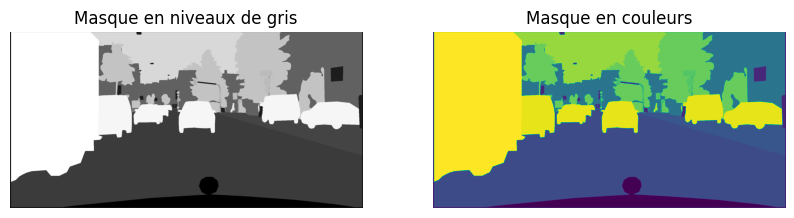

In [74]:
# affichage
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1), plt.imshow(labels, cmap='gray')
plt.title('Masque en niveaux de gris')
plt.axis('off')
plt.subplot(2, 2, 2), plt.imshow(labels)
plt.title('Masque en couleurs')
plt.axis('off');

# Préparation des données

Démarche : nous n'avons pas sélectionné tout le dataset, pour des raisons de ressources. Nous avons sélectionné certaines villes pour constituer les datasets train, val et test, selon un ratio de 80:20 environ pour le train et le val, et environ 10% pour le dataset test. 

In [45]:
def load_image(image_path, size=(128, 128)):
    # Ouvrir l'image, redimensionner et normaliser
    image = Image.open(image_path).resize(size)
    return np.array(image) / 255.0  # Normalized RGB image

def load_mask(mask_path, size=(128, 128)):
    # Ouvrir le masque et le redimensionner
    mask = Image.open(mask_path).resize(size)
    return np.array(mask)  # Label IDs (no normalization)

In [46]:
train_images = []
train_masks = []
val_images = []
val_masks = []
test_images = []
test_masks = []

# chemins des répertoires
train_images_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_X/X_train_stuttgart_tubingen_strasbourg_ulm_bremen_hamburg_zurich"
train_masks_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_y/y_train_mask_stuttgart_tubingen_strasbourg_ulm_bremen_hamburg_zurich"
val_images_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_X/X_val_frankfurt"
val_masks_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_y/y_val_mask_frankfurt"
test_images_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_X/X_test_jena"
test_masks_dir = "C:/Users/Engasser Ophélie/Desktop/DR_Project/data_y/y_test_mask_jena"

# chargement des images et des masques pour l'ensemble d'entraînement
for filename in os.listdir(train_images_dir):
    if filename.endswith('_leftImg8bit.png'):
        image_path = os.path.join(train_images_dir, filename)
        mask_filename = filename.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
        mask_path = os.path.join(train_masks_dir, mask_filename)

        if os.path.exists(mask_path):
            image = load_image(image_path, size=(128, 128))
            mask = load_mask(mask_path, size=(128, 128))
            
            train_images.append(image)
            train_masks.append(mask)

# chargement des images et des masques pour l'ensemble de validation
for filename in os.listdir(val_images_dir):
    if filename.endswith('_leftImg8bit.png'):
        image_path = os.path.join(val_images_dir, filename)
        mask_filename = filename.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
        mask_path = os.path.join(val_masks_dir, mask_filename)

        if os.path.exists(mask_path):
            image = load_image(image_path, size=(128, 128))
            mask = load_mask(mask_path, size=(128, 128))
            
            val_images.append(image)
            val_masks.append(mask)

# chargement des images et des masques pour l'ensemble de test
for filename in os.listdir(test_images_dir):
    if filename.endswith('_leftImg8bit.png'):
        image_path = os.path.join(test_images_dir, filename)
        mask_filename = filename.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
        mask_path = os.path.join(test_masks_dir, mask_filename)

        if os.path.exists(mask_path):
            image = load_image(image_path, size=(128, 128))
            mask = load_mask(mask_path, size=(128, 128))
            
            test_images.append(image)
            test_masks.append(mask)

# convertir les listes en tableaux numpy
train_images = np.array(train_images)
train_masks = np.array(train_masks)
val_images = np.array(val_images)
val_masks = np.array(val_masks)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

In [39]:
print(train_images.shape, train_masks.shape, val_images.shape, val_masks.shape, test_images.shape, test_masks.shape)

(1486, 128, 128, 3) (1486, 128, 128) (267, 128, 128, 3) (267, 128, 128) (119, 128, 128, 3) (119, 128, 128)


In [22]:
train_masks[0]

array([[ 8, 10, 10, ..., 10, 10,  8],
       [15, 21, 21, ..., 21, 21, 16],
       [15, 21, 21, ..., 21, 21, 16],
       ...,
       [ 6,  7,  7, ...,  7,  7,  6],
       [ 6,  7,  7, ...,  7,  7,  6],
       [ 4,  4,  4, ...,  5,  5,  4]], dtype=uint8)

In [82]:
np.unique(train_masks)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=uint8)

Les masques sont encodés avec les 34 labels. Il faut mapper les labels avec leurs catégories (8 en tout).

In [47]:
def remap_labels_to_categories(mask):
    label_id_to_category_id = {
        0: 0,  # 'void'
        1: 0,  # 'void'
        2: 0,  # 'void'
        3: 0,  # 'void'
        4: 0,  # 'void'
        5: 0,  # 'void'
        6: 0,  # 'void'
        7: 1,  # 'flat'
        8: 1,  # 'flat'
        9: 1,  # 'flat'
        10: 1,  # 'flat'
        11: 2,  # 'construction'
        12: 2,  # 'construction'
        13: 2,  # 'construction'
        14: 2,  # 'construction'
        15: 2,  # 'construction'
        16: 2,  # 'construction'
        17: 3,  # 'object'
        18: 3,  # 'object'
        19: 3,  # 'object'
        20: 3,  # 'object'
        21: 4,  # 'nature'
        22: 4,  # 'nature'
        23: 5,  # 'sky'
        24: 6,  # 'human'
        25: 6,  # 'human'
        26: 7,  # 'vehicle'
        27: 7,  # 'vehicle'
        28: 7,  # 'vehicle'
        29: 7,  # 'vehicle'
        30: 7,  # 'vehicle'
        31: 7,  # 'vehicle'
        32: 7,  # 'vehicle'
        33: 7,  # 'vehicle'
        -1: 7   # 'vehicle'
    }

    # exclure les valeurs du masque qui ne sont pas présentes dans le dictionnaire
    mask[mask < 0] = 0
    mask[mask > 33] = 0

    # remapping de chaque valeur du masque à son identifiant de catégorie correspondant
    remapped_mask = np.vectorize(label_id_to_category_id.get)(mask)
    return remapped_mask

# remapping des masques dans train_masks, val_masks et test_masks
remapped_train_masks = np.array([remap_labels_to_categories(mask) for mask in train_masks])
remapped_val_masks = np.array([remap_labels_to_categories(mask) for mask in val_masks])
remapped_test_masks = np.array([remap_labels_to_categories(mask) for mask in test_masks])

In [83]:
np.unique(remapped_train_masks)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [42]:
print(remapped_train_masks.shape, remapped_val_masks.shape, remapped_test_masks.shape)

(1486, 128, 128) (267, 128, 128) (119, 128, 128)


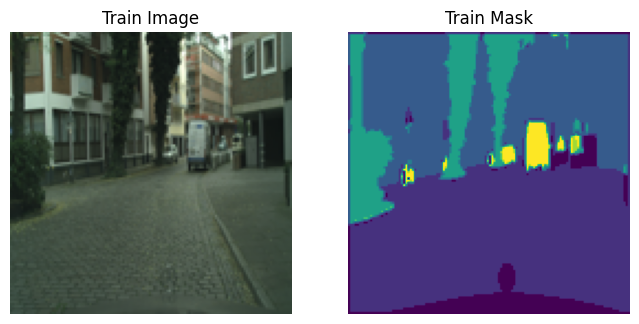

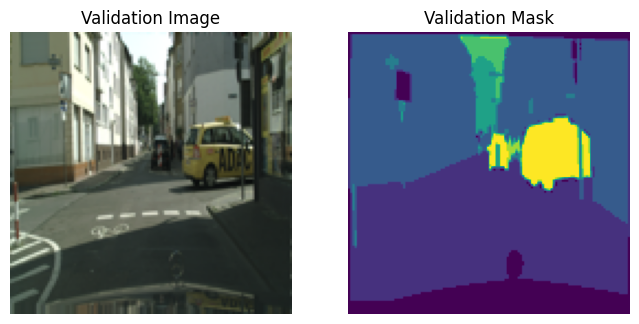

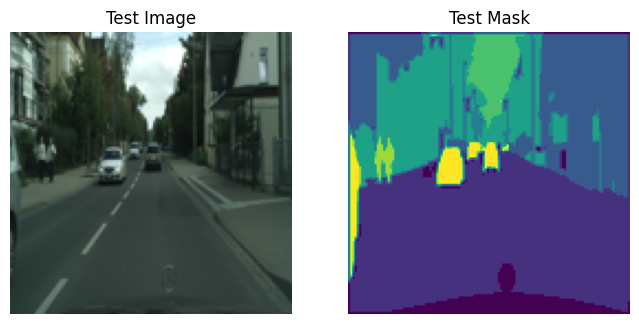

In [85]:
# train
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.title('Train Image')
plt.imshow(train_images[0])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Train Mask')
plt.imshow(remapped_train_masks[0])
plt.axis('off')
plt.show()

# val
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.title('Validation Image')
plt.imshow(val_images[0])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Validation Mask')
plt.imshow(remapped_val_masks[0])
plt.axis('off')
plt.show()

# test
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.title('Test Image')
plt.imshow(test_images[0])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Test Mask')
plt.imshow(remapped_test_masks[0])
plt.axis('off')
plt.show()

# Implémentation du modèle U-NET

In [5]:
# création d'une classe pour ajouter la métrique IoU dans le fit
from tensorflow.keras.metrics import MeanIoU

class UpdatedMeanIoU(MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # bridge

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # decoder 
    
    up4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # output layer
    outputs = Conv2D(8, 1, activation='softmax')(conv5) # 8 classes de sortie

    # créer le modèle
    model = Model(inputs=inputs, outputs=outputs)
    return model

# créer une instance du modèle U-Net
model = unet()

# compiler le modèle
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', UpdatedMeanIoU(num_classes=8, name = "mean_iou")])

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,863,304 (7.11 MB)

 Trainable params: 1,863,304 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# paramètres
TRAIN_LENGTH = len(train_images)
BATCH_SIZE = 64
BUFFER_SIZE = 1000  # nb d'éléments à garder en mémoire tampon lors du shuffle
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(val_images) // BATCH_SIZE // VAL_SUBSPLITS

# préparation des datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, remapped_train_masks))
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, remapped_val_masks))
val_dataset = val_dataset.batch(BATCH_SIZE)

# Entraînement

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 360s 15s/step - accuracy: 0.3856 - loss: 1.6930 - mean_iou: 0.0918 - val_accuracy: 0.4704 - val_loss: 1.4609 - val_mean_iou: 0.1446
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 294s 13s/step - accuracy: 0.5387 - loss: 1.2937 - mean_iou: 0.2300 - val_accuracy: 0.5644 - val_loss: 1.1870 - val_mean_iou: 0.2606
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 315s 14s/step - accuracy: 0.6210 - loss: 1.0707 - mean_iou: 0.2971 - val_accuracy: 0.6019 - val_loss: 1.1072 - val_mean_iou: 0.2743
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 317s 14s/step - accuracy: 0.6479 - loss: 1.0147 - mean_iou: 0.3160 - val_accuracy: 0.6639 - val_loss: 0.9969 - val_mean_iou: 0.3218
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 316s 14s/step - accuracy: 0.6881 - loss: 0.9231 - mean_iou: 0.3589 - val_accuracy: 0.6957 - val_loss: 0.9077 - val_mean_iou: 0.3740
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 323s 14s/step - accuracy: 0.7170 - loss: 0.8525 - mean_iou: 0.3977 - val_accuracy: 0.7066 - val_loss: 0.88

# Evaluation

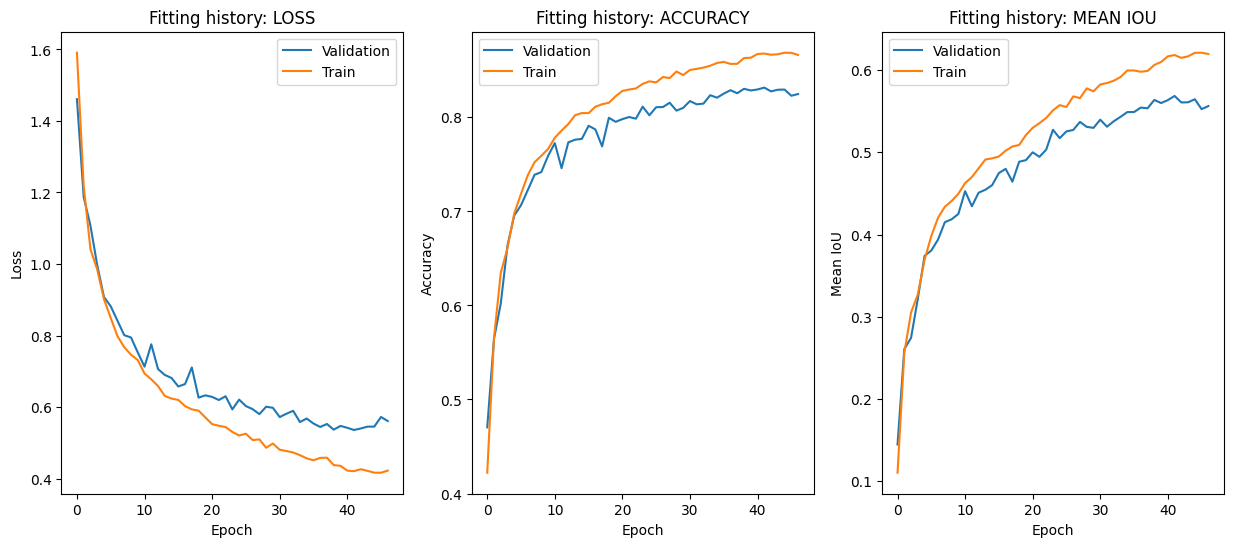

In [31]:
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.plot(model_history.history['val_loss'])
plt.plot(model_history.history['loss'])
plt.title("Fitting history: LOSS")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper right')

plt.subplot(1,3,2)
plt.plot(model_history.history['val_accuracy'])
plt.plot(model_history.history['accuracy'])
plt.title("Fitting history: ACCURACY")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper left')

plt.subplot(1,3,3)
plt.plot(model_history.history['val_mean_iou'])
plt.plot(model_history.history['mean_iou'])
plt.title("Fitting history: MEAN IOU")
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper left')

plt.show()

Les courbes mettent en évidence un apprentissage régulier avec une bonne stabilité, avec toutefois un surapprentissage.

In [41]:
from tensorflow.keras.models import load_model

In [ ]:
# sauvegarde
model.save('model.h5')

In [ ]:
# chargement
model = load_model('model.h5')

# Prédictions

In [51]:
# prédictions
pred_masks = model.predict(test_images)

# convertir les prédictions en masques de classe (chaque pixel prend la valeur de la classe avec la probabilité la plus élevée)
pred_masks = np.argmax(pred_masks, axis=-1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


In [58]:
np.unique(pred_masks)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

Les 8 classes sont bien représentées.

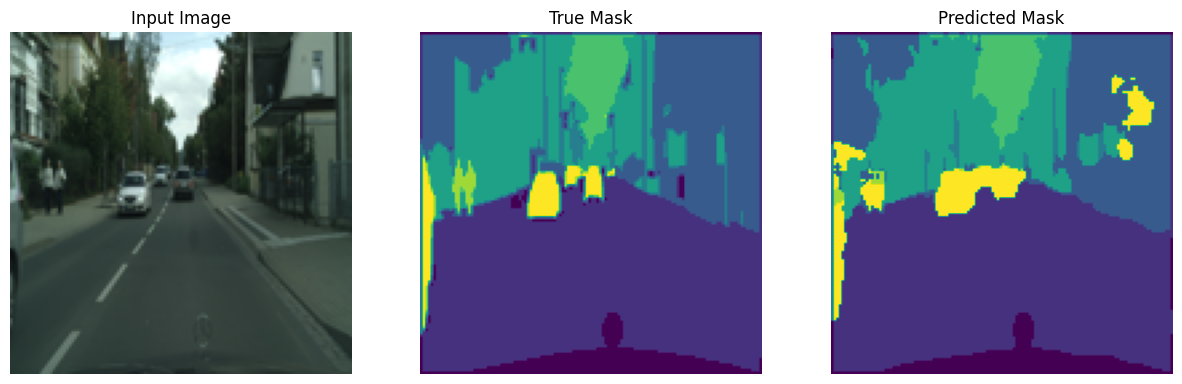

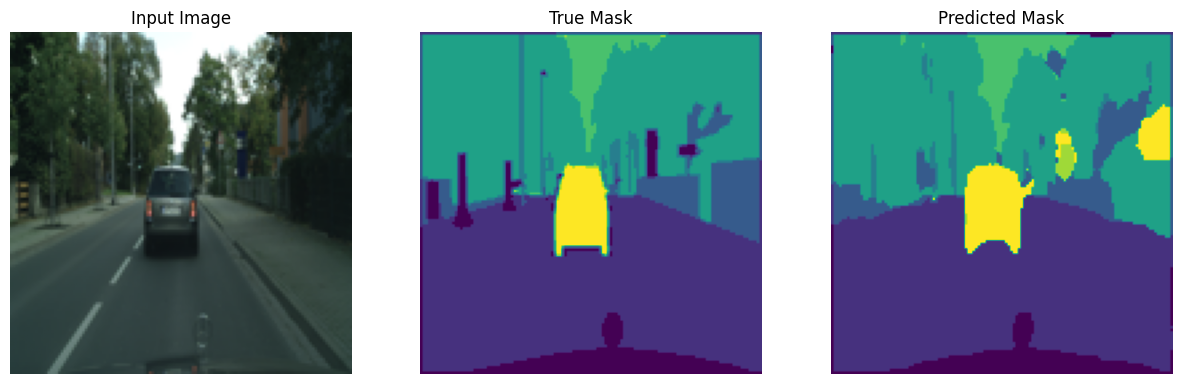

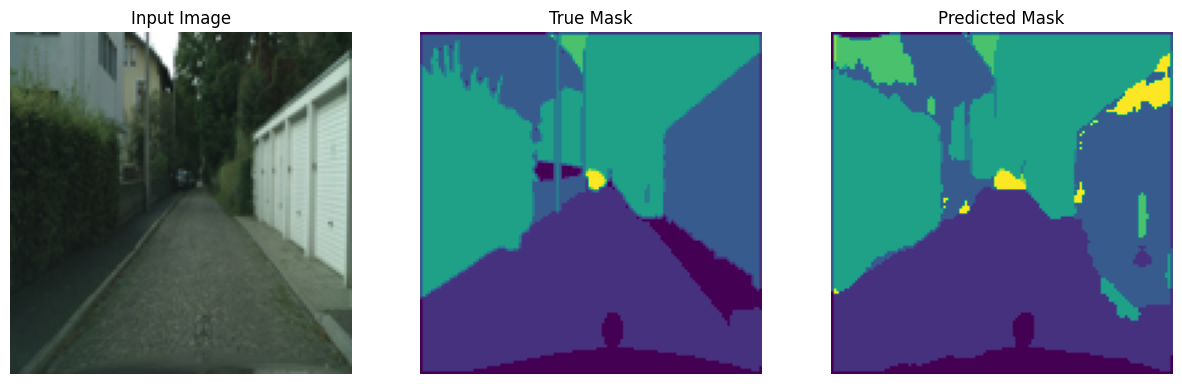

In [86]:
# visu
num_examples = 3
for i in range(num_examples):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(remapped_test_masks[i])
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_masks[i])
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

Nous nous intéressons à la métrique IoU (Intersection over Union) : l'intersection représente le nombre de pixels communs entre les prédictions et la vérité-terrain, et l'union représente le chevauchement des deux.
$$IoU = \frac{Aire\ intersection}{Aire\ union}$$
Il s'agit d'une métrique pertinente dans la tâche de segmentation sémantique dans le sens où elle nous apporte une observation du nombre de pixels bien classés, en d'autres termes la précision spatiale des masques de prédictions. 

In [92]:
def iou_metric(y_true, y_pred, num_classes):
    ious = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls)
        union = np.logical_or(y_true == cls, y_pred == cls)
        if np.sum(union) == 0:
            iou_score = float('nan')  # évite la division par zéro
        else:
            iou_score = np.sum(intersection) / np.sum(union)
        ious.append(iou_score)
    return ious

In [37]:
# IoU pour chaque classe
num_classes = 8
ious = [] # ious pour chaque classe pour chaque paire de masques
for true_mask, pred_mask in zip(remapped_test_masks, pred_masks):
    ious.append(iou_metric(true_mask, pred_mask, num_classes))

# IoU moyen
mean_iou_per_class = np.mean(ious, axis=0)
mean_iou = np.mean(mean_iou_per_class)

In [39]:
mean_iou.round(2)

0.52

In [40]:
mean_iou_per_class.round(2)

array([0.66, 0.85, 0.69, 0.11, 0.61, 0.58, 0.16, 0.5 ])

In [32]:
class_names = ['void', 'flat', 'construction', 'object', 'nature', 'sky', 'human', 'vehicle']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=class_names,
    y=mean_iou_per_class,
    text=mean_iou_per_class.round(2),
    textposition='outside',
    marker_color='lightblue'
))

fig.update_layout(
    title='Mean IoU per class',
    xaxis_title='Class',
    yaxis_title='Mean IoU',
    yaxis=dict(range=[0, 1], gridcolor='lightgrey'),
    plot_bgcolor='white'
)

fig.show()

On observe que les classes présentant le moins d'items bien classés sont les objets et les humains. Si l'on observe les masques prédits, on voit effectivement que les piétons sont assimilés à des voitures (ce qui est pas un résultat à améliorer ++ si l'on souhaite appliquer le modèle à la conduite automone). Ce résultat s'explique par le fait que les objets et piétons sont les polygones qui sont les plus petits sur les images, donc ceux qui présentent le moins de pixels susceptibles d'être bien appris par le modèle. Par ailleurs, si l'on observe les images, on voit que les piétons sont assez faciles à distinguer par l'oeil humain qui a une conscience de leur forme, mais en terme de contraste de pixels, ils peuvent être difficiles à différencier et à extraire pour un modèle.

Concernant les pixels des classes les mieux prédites, on voit que ce sont des régions vastes des photos, le modèle apprend donc sur beaucoup plus de pixels et est donc meilleur pour les détecter.

In [42]:
!pip install scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.0 MB 2.6 MB/s eta 0:00:05
   - -------------------------------------- 0.4/11.0 MB 3.8 MB/s eta 0:00:03
   -- ------------------------------------- 0.6/11.0 MB 4.5 MB/s eta 0:00:03
   --- ------------------------------------ 1.0/11.0 MB 5.3 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/11.0 MB 5.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/11.0 MB 5.8 MB/s eta 0:00:02
   ------- -------------------------------- 2.0/11.0 MB 6.3 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.0 MB 6.5 MB/s eta 0:00:02
   --------- ------------------------------ 2.7/11.0 MB 6.6 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/11.0 MB 6.9 MB/s eta 0:00:02
   ------------ --------------------------- 3.5/11.0 MB 7.0 MB/s eta 0:00:02
   ------------- -------------------------- 3.8/11.0 MB 7.0 MB/s eta 0:00:02
   ---

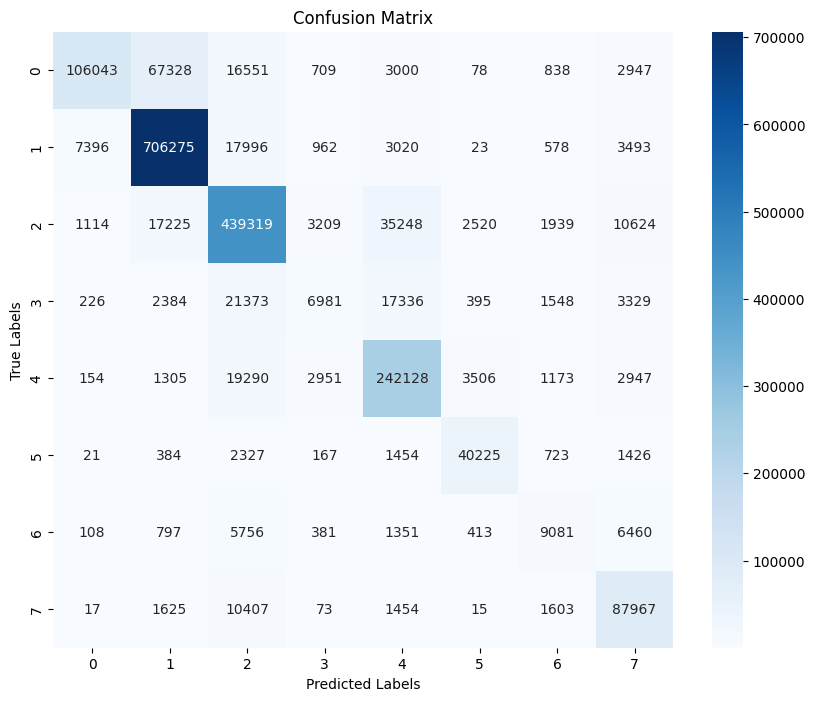

In [48]:
from sklearn.metrics import confusion_matrix

# aplatir les masques pour obtenir une liste d'étiquettes de pixels
y_true = remapped_test_masks.flatten()
y_pred = pred_masks.flatten()

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [49]:
from sklearn.metrics import classification_report

class_report = classification_report(y_true, y_pred)
print("Classification Report:\n")
print(class_report)

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.54      0.68    197494
           1       0.89      0.95      0.92    739743
           2       0.82      0.86      0.84    511198
           3       0.45      0.13      0.20     53572
           4       0.79      0.89      0.84    273454
           5       0.85      0.86      0.86     46727
           6       0.52      0.37      0.43     24347
           7       0.74      0.85      0.79    103161

    accuracy                           0.84   1949696
   macro avg       0.75      0.68      0.70   1949696
weighted avg       0.84      0.84      0.83   1949696



In [38]:
class_names = ['void', 'flat', 'construction', 'object', 'nature', 'sky', 'human', 'vehicle']
precision = [.92, .89, .82, .45, .79, .85, .52, .74]
recall = [.54, .95, .86, .13, .89, .86, .37, .85]
f1_score = [.68, .92, .84, .20, .84, .86, .43, .79]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=class_names,
    y=precision,
    name='Precision',
    text=precision,
    textposition='outside',
    marker_color='lightblue'
))

fig.add_trace(go.Bar(
    x=class_names,
    y=recall,
    name='Recall',
    text=recall,
    textposition='outside',
    marker_color='steelblue'
))

fig.add_trace(go.Bar(
    x=class_names,
    y=f1_score,
    name='F1 Score',
    text=f1_score,
    textposition='outside',
    marker_color='darkblue'
))

fig.update_layout(
    title='Performance Metrics per class',
    xaxis_title='Class',
    yaxis_title='Score',
    yaxis=dict(range=[0, 1], gridcolor='lightgrey'),
    plot_bgcolor='white',
    barmode='group'  # Grouper les barres par classe
)

fig.show()

On observe les mêmes tendances concernant les métriques précision, rappel et f1-score que pour l'IoU, à savoir de moindres performances sur les classes objets et humains. Les métriques sont relativement cohérentes à l'intérieur d'une même classe, à part pour 'void' qui présente une bonne précision mais un faible rappel (idem pour 'object'). Par ex. pour les objets, cela signifie que lorsque le modèle prédit un objet alors cela s'avère à 45% juste (prédiction), mais il peine à les détecter (13% de rappel). Comme nous l'avons mentionné, cela s'explique par une sous-représentation de ces classes dans le dataset.

Nous allons utiliser la librairie optuna afin d'optimiser les hyperparamètres de manière automatisée. Puis nous utiliserons l'objet de sortie d'optuna pour réentraîner le modèle avec les meilleurs hyperparamètres. Nous avons choisi de faire varier le nombre filtres pour chaque couche de neurones, ainsi que le learning rate.

# Utilisation d'optuna pour améliorer les hyperparametres

In [1]:
!pip install optuna
!pip install optuna-integration

   ---------------------------------------- 0.0/380.1 kB ? eta -:--:--
   ------- -------------------------------- 71.7/380.1 kB 1.9 MB/s eta 0:00:01
   ------------ --------------------------- 122.9/380.1 kB 1.8 MB/s eta 0:00:01
   -------------------------- ------------- 256.0/380.1 kB 2.0 MB/s eta 0:00:01
   ------------------------------------- -- 358.4/380.1 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 380.1/380.1 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.4 kB ? eta -:--:--
   --------------- ------------------------ 92.2/233.4 kB 1.7 MB/s eta 0:00:01
   ------------------- -------------------- 112.6/233.4 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 233.4/233.4 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.1 MB 3.8 MB/s eta 0:00:01
   --- ------------------------------------ 0.2/2.1 MB 2.6 MB/s eta 0:00:01

In [6]:
import optuna
from optuna.integration import TFKerasPruningCallback
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(trial):
    inputs = Input(shape=(128, 128, 3))
    
    # hyperparameters to tune MODIFY HERE to add or remove hyperparameters optuna will search for the best value
    n_filters = trial.suggest_categorical('n_filters', [32, 64])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    
    # encoder
    conv1 = Conv2D(n_filters, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(n_filters * 2, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters * 2, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # bridge
    conv3 = Conv2D(n_filters * 4, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters * 4, 3, activation='relu', padding='same')(conv3)

    # decoder
    up4 = Conv2DTranspose(n_filters * 2, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(n_filters * 2, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(n_filters * 2, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(n_filters, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(n_filters, 3, activation='relu', padding='same')(conv5)

    # output layer
    outputs = Conv2D(8, 1, activation='softmax')(conv5)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy', UpdatedMeanIoU(num_classes=8)])
    return model

def objective(trial):
    model = unet_model(trial)
    
    TRAIN_LENGTH = len(train_images)
    BATCH_SIZE = 64
    BUFFER_SIZE = 1000
    STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
    EPOCHS = 100
    VAL_SUBSPLITS = 5
    VALIDATION_STEPS = len(val_images) // BATCH_SIZE // VAL_SUBSPLITS

    # préparation des datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, remapped_train_masks))
    train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, remapped_val_masks))
    val_dataset = val_dataset.batch(BATCH_SIZE)

    history = model.fit(train_dataset,
                        epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data=val_dataset,
                        validation_steps=VALIDATION_STEPS,
                        callbacks=[TFKerasPruningCallback(trial, 'val_loss')],
                        verbose=0)
    
    return min(history.history['val_loss'])

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1) # MODIFY HERE n_trials to increase the number of trials the optuna will run to find the best hyperparameters

[I 2024-06-05 09:13:46,221] A new study created in memory with name: no-name-976d0bc8-da94-4151-8588-4a8dc8d08c64
C:\Users\Engasser Ophélie\AppData\Local\Temp\ipykernel_39152\3779512948.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
[I 2024-06-05 19:59:41,910] Trial 0 finished with value: 0.5540214776992798 and parameters: {'n_filters': 64, 'learning_rate': 0.00027647990450630345}. Best is trial 0 with value: 0.5540214776992798.


A présent il est possible d'entraîner un nouveau modèle avec les meilleurs hyperparamètres.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

best_params = study.best_params
best_params

def unet_model(best_params):
    inputs = Input(shape=(128, 128, 3))
    
    # hyperparameters to tune MODIFY HERE to add or remove hyperparameters optuna will search for the best value
    n_filters = best_params['n_filters']
    
    # encoder
    conv1 = Conv2D(n_filters, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(n_filters * 2, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters * 2, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # bridge
    conv3 = Conv2D(n_filters * 4, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters * 4, 3, activation='relu', padding='same')(conv3)

    # decoder
    up4 = Conv2DTranspose(n_filters * 2, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(n_filters * 2, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(n_filters * 2, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(n_filters, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(n_filters, 3, activation='relu', padding='same')(conv5)

    # output layer
    outputs = Conv2D(8, 1, activation='softmax')(conv5)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

model = unet_model(best_params)

TRAIN_LENGTH = len(train_images)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 100
model.compile(optimizer=tf.keras.optimizers.Adam(best_params['learning_rate']),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', UpdatedMeanIoU(num_classes=8, name = "mean_iou")])

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 362s 14s/step - accuracy: 0.3388 - loss: 1.9724 - mean_iou: 0.0575 - val_accuracy: 0.3924 - val_loss: 1.7324 - val_mean_iou: 0.0491
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 323s 15s/step - accuracy: 0.3887 - loss: 1.6892 - mean_iou: 0.0501 - val_accuracy: 0.4852 - val_loss: 1.4667 - val_mean_iou: 0.1056
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 339s 15s/step - accuracy: 0.4986 - loss: 1.4482 - mean_iou: 0.1186 - val_accuracy: 0.5406 - val_loss: 1.3217 - val_mean_iou: 0.1659
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 342s 15s/step - accuracy: 0.5664 - loss: 1.2370 - mean_iou: 0.1912 - val_accuracy: 0.5960 - val_loss: 1.1735 - val_mean_iou: 0.2541
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 335s 14s/step - accuracy: 0.6435 - loss: 1.0643 - mean_iou: 0.3036 - val_accuracy: 0.6325 - val_loss: 1.0842 - val_mean_iou: 0.2890
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 350s 15s/step - accuracy: 0.6602 - loss: 1.0020 - mean_iou: 0.3230 - val_accuracy: 0.6475 - val_loss: 1.03

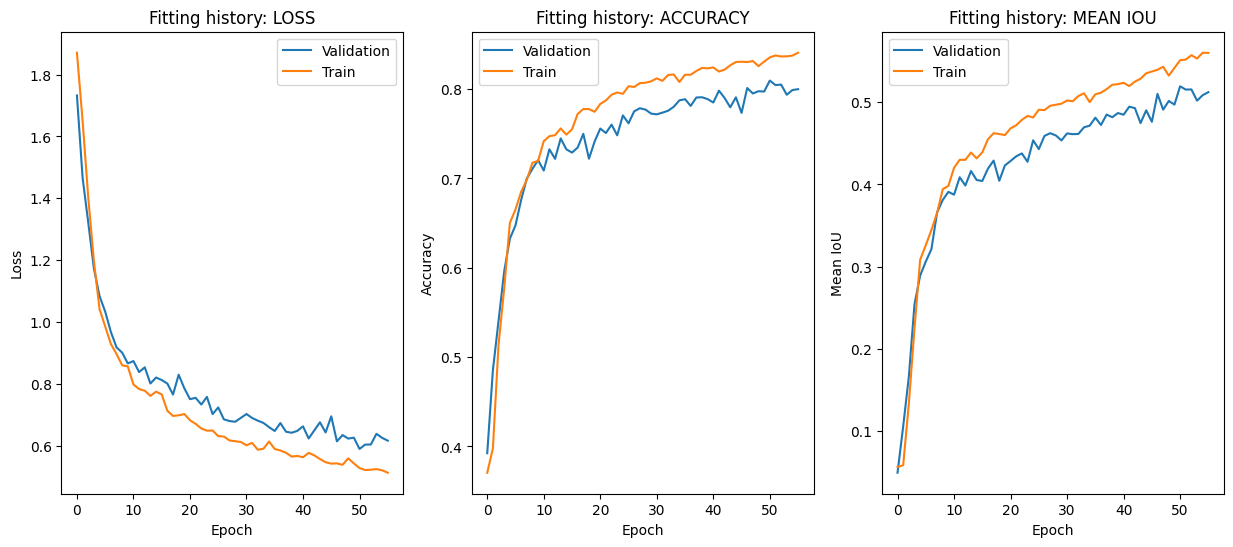

In [12]:
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.plot(model_history.history['val_loss'])
plt.plot(model_history.history['loss'])
plt.title("Fitting history: LOSS")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper right')

plt.subplot(1,3,2)
plt.plot(model_history.history['val_accuracy'])
plt.plot(model_history.history['accuracy'])
plt.title("Fitting history: ACCURACY")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper left')

plt.subplot(1,3,3)
plt.plot(model_history.history['val_mean_iou'])
plt.plot(model_history.history['mean_iou'])
plt.title("Fitting history: MEAN IOU")
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc = 'upper left')

plt.show()

In [ ]:
# sauvegarde
model.save('model_optim.h5')

In [ ]:
# chargement
model_optim = load_model('model_optim.h5')

In [88]:
# prédictions
pred_masks_optim = model_optim.predict(test_images)

# convertir les prédictions en masques de classe (chaque pixel prend la valeur de la classe avec la probabilité la plus élevée)
pred_masks_optim = np.argmax(pred_masks_optim, axis=-1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


In [89]:
np.unique(pred_masks_optim)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

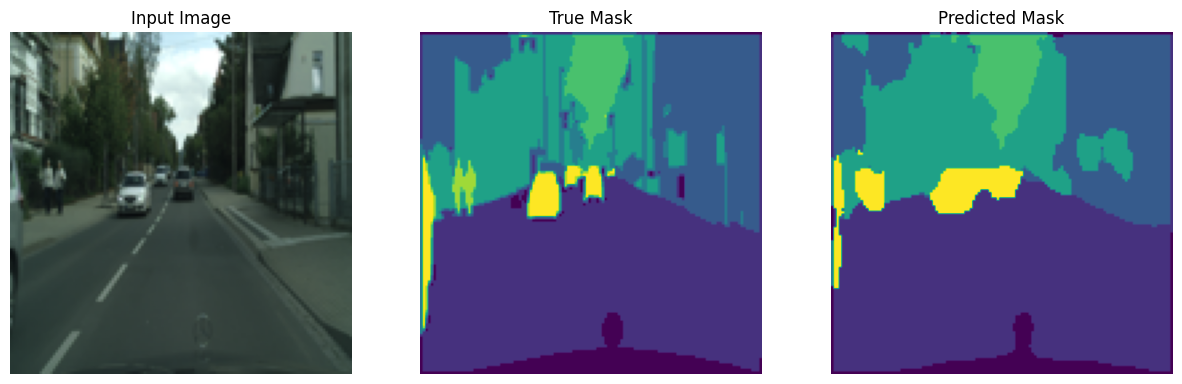

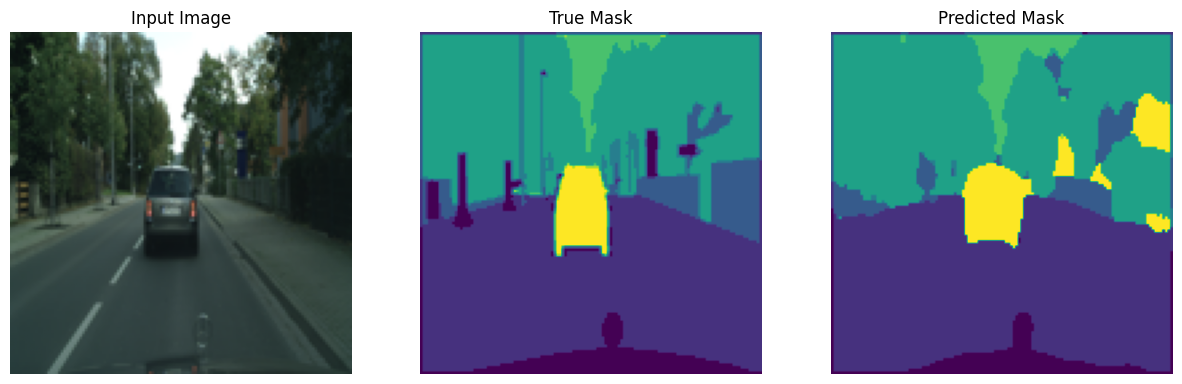

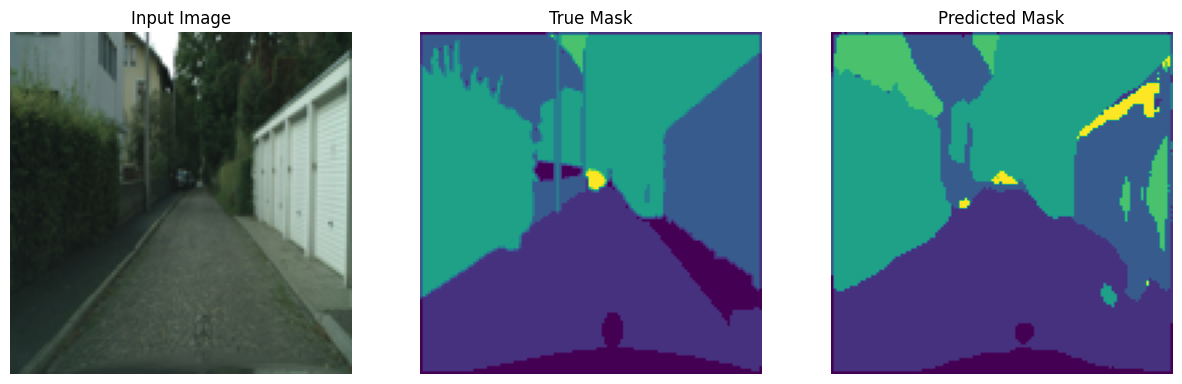

In [90]:
# visu
num_examples = 3
for i in range(num_examples):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(remapped_test_masks[i])
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_masks_optim[i])
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

In [93]:
# IoU pour chaque classe
num_classes = 8
ious = [] # ious pour chaque classe pour chaque paire de masques
for true_mask, pred_mask in zip(remapped_test_masks, pred_masks_optim):
    ious.append(iou_metric(true_mask, pred_masks_optim, num_classes))

# IoU moyen
mean_iou_per_class = np.mean(ious, axis=0)
mean_iou = np.mean(mean_iou_per_class)

In [94]:
mean_iou.round(2)

0.24

In [95]:
mean_iou_per_class.round(2)

array([0.56, 0.69, 0.32, 0.01, 0.16, 0.09, 0.01, 0.08])

In [30]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=class_names,
    y=mean_iou_per_class,
    text=mean_iou_per_class.round(2),
    textposition='outside',
    marker_color='lightblue'
))

fig.update_layout(
    title='Mean IoU per class',
    xaxis_title='Class',
    yaxis_title='Mean IoU',
    yaxis=dict(range=[0, 1], gridcolor='lightgrey'),
    plot_bgcolor='white'
)

fig.show()

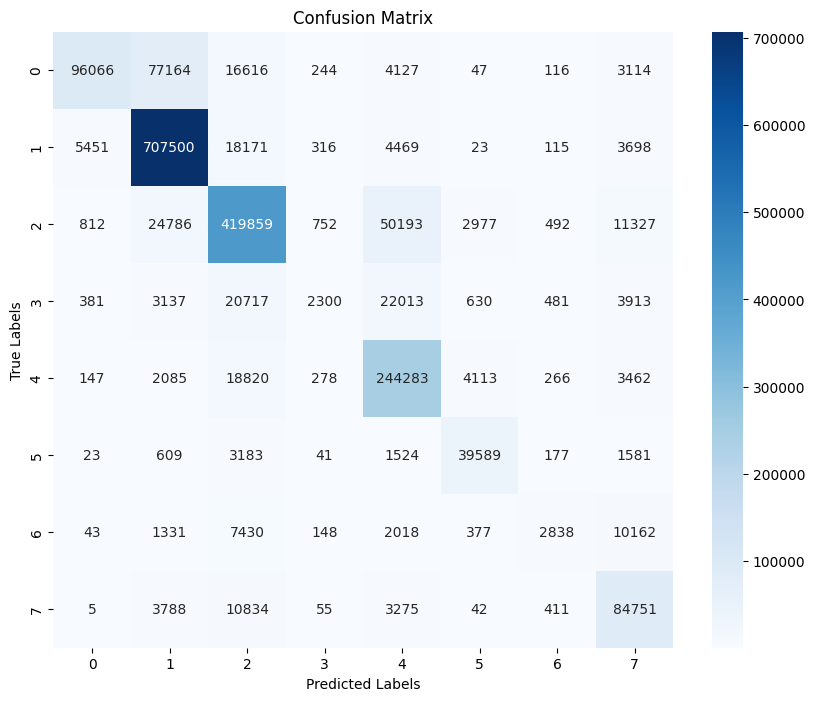

In [34]:
# aplatir les masques pour obtenir une liste d'étiquettes de pixels
y_true = remapped_test_masks.flatten()
y_pred = pred_masks_optim.flatten()

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [35]:
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n")
print(class_report)

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.49      0.64    197494
           1       0.86      0.96      0.91    739743
           2       0.81      0.82      0.82    511198
           3       0.56      0.04      0.08     53572
           4       0.74      0.89      0.81    273454
           5       0.83      0.85      0.84     46727
           6       0.58      0.12      0.19     24347
           7       0.69      0.82      0.75    103161

    accuracy                           0.82   1949696
   macro avg       0.75      0.62      0.63   1949696
weighted avg       0.82      0.82      0.80   1949696



# Discussion

L'optimisation avec optuna n'a pas permis d'améliorer les performances du modèle, elles sont même légèrement inférieures à celles obtenues avec le modèle de base. Il est à noter que nous n'avons fait varier, pour des raisons de manque de ressources en calcul, que les paramètres n_filters et learning_rate (et même avec cela, la pipeline a tourné 8 heures). Un axe d'amélioration serait d'augmenter la pipeline avec plus d'hyperparamètres à tester, et ce sur des plages plus larges. 

Par ailleurs, nous avons observé au cours de ce travail que l'augmentation progressive du nombre de villes dans les données d'entraînement a permis d'améliorer considérablement le modèle ainsi que de le rendre plus stable. Un autre axe d'amélioration serait d'augmenter encore le nombre de données d'entrées, voire, si cela était possible, d'utiliser l'entièreté des données.

Une autre remarque concerne enfin les limites d'un modèle de segmentation sémantique d'images pour un cas d'usage de conduite autonome. En effet, nous avons ici utilisé 8 catégories d'objets potentiels, le dataset en contient 34. Mais en réalité, une scène visuelle en conduite automobile admet un nombre beaucoup plus important de classes.

Pour aller plus loin, nous avons conçu une application Flask permettant à un utilisateur de charger une image ou une vidéo, et d'appliquer notre modèle en temps réel (cf.fichiers dédiés).